In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [3]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [4]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 45.3 MB/s eta 0:00:00
/content/drive/MyDrive/Colab Notebooks


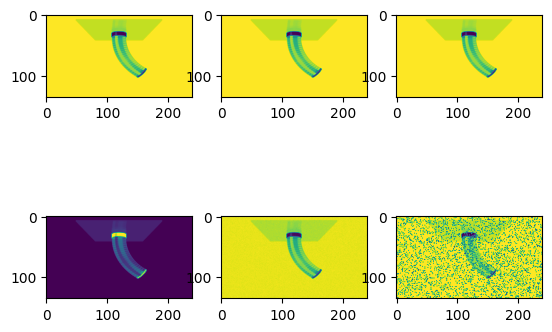

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


(513, 135, 240, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


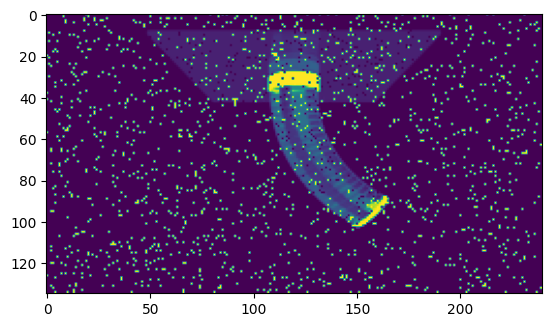

In [5]:
%run DataAugmentation.ipynb

### Offline Data Augmentation

In [6]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, target_size=(224, 224),
    train_perc=0.6, eval_perc=0.2, test_perc=0.2, **augmentation_configuration,
  )

In [7]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [8]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
print(len(train_images), len(train_tip_pos))

1842 1842


In [12]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
58/58 [==============================] - 12s 50ms/step - loss: 22.0132 - mean_absolute_error: 3.3414 - mean_euclidean_error: 6.8087 - val_loss: 5.6205 - val_mean_absolute_error: 1.6812 - val_mean_euclidean_error: 3.4994
Epoch 2/100
58/58 [==============================] - 2s 29ms/step - loss: 3.0234 - mean_absolute_error: 1.1633 - mean_euclidean_error: 2.4685 - val_loss: 1.8808 - val_mean_absolute_error: 0.8440 - val_mean_euclidean_error: 1.8120
Epoch 3/100
58/58 [==============================] - 2s 29ms/step - loss: 1.4430 - mean_absolute_error: 0.7906 - mean_euclidean_error: 1.6686 - val_loss: 1.1242 - val_mean_absolute_error: 0.6544 - val_mean_euclidean_error: 1.3935
Epoch 4/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9674 - mean_absolute_error: 0.6529 - mean_euclidean_error: 1.3712 - val_loss: 0.8136 - val_mean_absolute_error: 0.5526 - val_mean_euclidean_error: 1.1811
Epoch 5/100
58/58 [==============================] - 2s 29ms/step - loss: 0.79

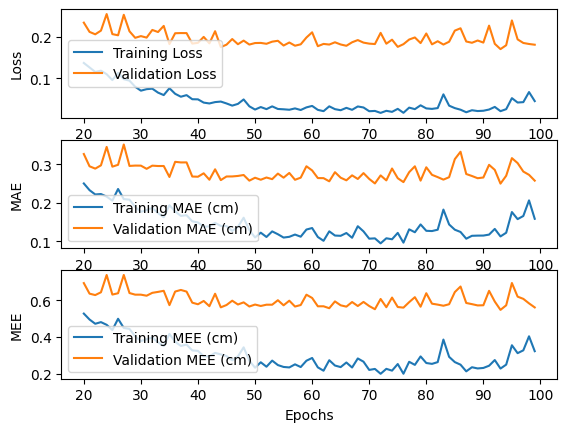

In [16]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 26ms/step
103 103 103
103 103 103
x-axis: mean = 0.33902305427775276, std = 1.4610355964015567
y-axis: mean = 0.04498532802027648, std = 0.07517411635319494
z-axis: mean = 0.008045202217610027, std = 0.012022495150414059


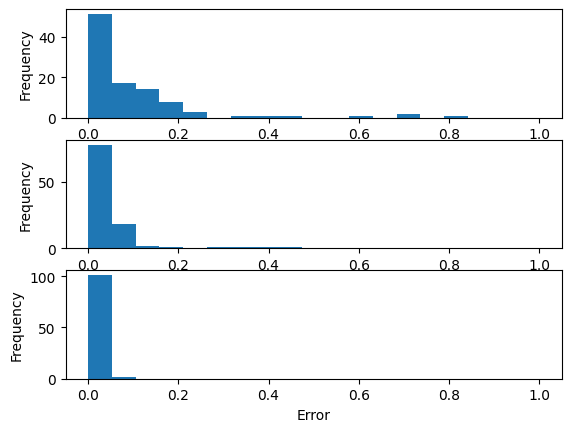

In [17]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [18]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.2576315402984619
Std of MAE: 0.21510332822799683
Mean of MEE: 0.5606058806878803
Std of MEE: 0.4770771679536926


We calculate them also along each axis:

In [19]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.46743023 0.17912018 0.1263442 ]
Std of Distance along axes: [0.47057803 0.18862855 0.13534865]


Now we save model and history:

In [20]:
model.save('offlineDataAugmentedFinetunedVGG19')

In [21]:
json.dump(history.history, open('offlineDataAugmentedFinetunedVGG19.json', 'w'))

In [22]:
del model

### Online Data Augmentation

#### VGG19

In [23]:
images, tip_pos = get_dataset(
    target_size=(224, 224),
    force_resize=False, rescale_coordinates=100,
)

(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [24]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [25]:
online_augmentation_configuration = {
    'apply_brightness_change': {'factor': 0.1},
    'apply_saturation_change': {'factor': 1},
    #'apply_inversion': {},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

In [26]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [27]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [29]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 2s 144ms/step - loss: 62.1947 - mean_absolute_error: 6.2530 - mean_euclidean_error: 12.6202 - val_loss: 49.6044 - val_mean_absolute_error: 5.8919 - val_mean_euclidean_error: 11.3409
Epoch 2/100
10/10 [==============================] - 0s 40ms/step - loss: 28.5284 - mean_absolute_error: 4.1594 - mean_euclidean_error: 8.3478 - val_loss: 17.4137 - val_mean_absolute_error: 3.0836 - val_mean_euclidean_error: 6.7637
Epoch 3/100
10/10 [==============================] - 0s 40ms/step - loss: 16.1603 - mean_absolute_error: 2.9929 - mean_euclidean_error: 6.4812 - val_loss: 13.8015 - val_mean_absolute_error: 2.6933 - val_mean_euclidean_error: 5.7827
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 11.4952 - mean_absolute_error: 2.4851 - mean_euclidean_error: 5.1668 - val_loss: 11.4051 - val_mean_absolute_error: 2.5239 - val_mean_euclidean_error: 5.2023
Epoch 5/100
10/10 [==============================] - 0s 39ms/step - l

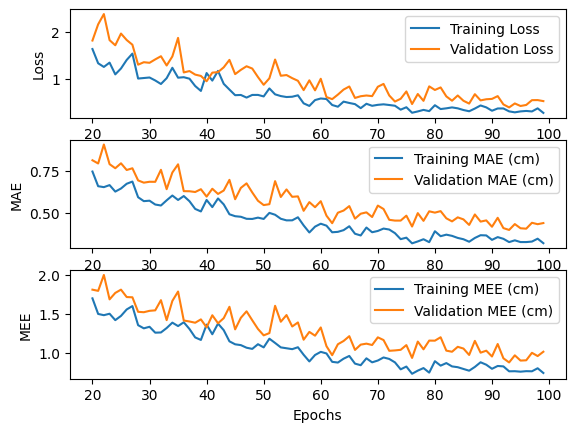

In [30]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 27ms/step
103 103 103
103 103 103
x-axis: mean = 0.8220268895695396, std = 3.9853740648060247
y-axis: mean = 0.0620251034622464, std = 0.14934359106893788
z-axis: mean = 0.01369529733300748, std = 0.017285686584085726


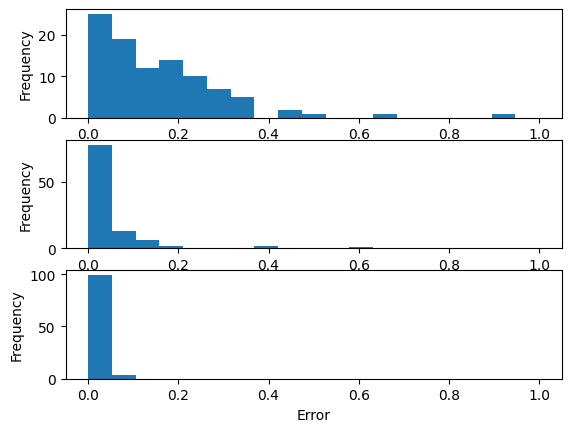

In [31]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [32]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.43907424807548523
Std of MAE: 0.3312501907348633
Mean of MEE: 0.9867185894487128
Std of MEE: 0.760738010428294


We calculate them also along each axis:

In [33]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.87730571 0.21259518 0.22732192]
Std of Distance along axes: [0.76803099 0.21341214 0.22445995]


Now we save model and history:

In [34]:
model.save('onlineDataAugmentedFinetunedVGG19')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [35]:
json.dump(history.history, open('onlineDataAugmentedFinetunedVGG19.json', 'w'))

In [36]:
del model